# Tutorial for estimation of continuous variables with regression using _ImaGene_

In this example, the aim is to estimate a continuous parameter using regression.
Please refer to the tutorial for binary and multiclass classification for an in-depth explanation of each step and case study, and to the tutorial for multiclass classification on continuous variables for data generation and processing.

In [1]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import pymc3

import skimage.transform
from keras import models, layers, activations, optimizers, regularizers
from keras.utils import plot_model
from keras.models import load_model

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pydot

Using TensorFlow backend.


In [2]:
%run -i ../ImaGene.py

### 1. read data from VCF file and store it into _ImaGene_ objects

As an illustration, we double sort the image by ordering rows and columns by frequency. We also filter out singletons and do not resize. 

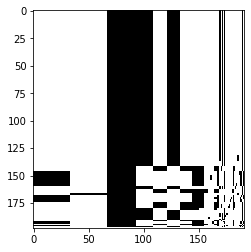

An object of 1 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

In [4]:
file_LCT = ImaFile(nr_samples=198, VCF_file_name='LCT.CEU.vcf')
gene_LCT = file_LCT.read_VCF()
gene_LCT.filter_freq(0.01)
gene_LCT.sort('rows_freq')
gene_LCT.sort('cols_freq')
gene_LCT.convert(flip=True)
gene_LCT.plot()
gene_LCT.summary()

### 2. run and process simulations to be used for training the neural network

See tutorial `03_multiclass_for_continuous`.

### 3. implement, train and evaluate the neural network

The pipeline for training and testing is the following one.
We resize all images to match the real data.

In [13]:
i = 1
while i <= 10:

    # simulations 
    file_sim = ImaFile(simulations_folder='/home/mfumagal/Downloads/ImaGene/Continuous/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

    # retain only 20 data points per class as a quick example
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=20)
    
    # manipulate data
    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.sort('cols_freq')
    gene_sim.resize((198, int(gene_LCT.dimensions[1][0])))
    gene_sim.convert(flip=True)
    
    # randomise data
    gene_sim.subset(get_index_random(gene_sim))
 
    # at first iteration we build the model 
    # noe that the last layer has a linear activation function
    if i == 1:

        model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1)])
        model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

        net_LCT = ImaNet(name='[C32+P]+[C64+P]+[C128+P]')

    # training for iterations from 1 to 9
    print(i)
    if i < 10:
        score = model.fit(gene_sim.data, gene_sim.targets, batch_size=32, epochs=1, verbose=1, validation_split=0.10)
        net_LCT.update_scores(score)
    else:
        # testing for iteration 10
        net_LCT.test = model.evaluate(gene_sim.data, gene_sim.targets, batch_size=None, verbose=1)
        net_LCT.predict(gene_sim, model)

    i += 1






1



Train on 7218 samples, validate on 802 samples
Epoch 1/1





7218/7218 [==============================] - 151s 21ms/step - loss: 11511.6615 - mean_absolute_error: 85.1899 - val_loss: 6117.9632 - val_mean_absolute_error: 61.6334
2
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 174s 24ms/step - loss: 6597.6969 - mean_absolute_error: 63.4244 - val_loss: 7910.4403 - val_mean_absolute_error: 66.7539
3
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 136s 19ms/step - loss: 6050.9392 - mean_absolute_error: 60.5980 - val_loss: 5165.8007 - val_mean_absolute_error: 56.9167
4
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [==============================] - 133s 18ms/step - loss: 5749.0922 - mean_absolute_error: 59.5165 - val_loss: 5047.8970 - val_mean_absolute_error: 55.4400
5
Train on 7218 samples, validate on 802 samples
Epoch 1/1
7218/7218 [================

In [14]:
# save final (trained) model
model.save('Data/model.cont.h5')

# save testing data
gene_sim.save('Data/gene_sim.cont')

# save network
net_LCT.save('Data/net_LCT.cont')

0

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

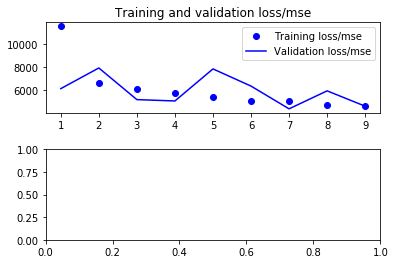

In [15]:
# assess the training
net_LCT.plot_train()

For the estimation of continuous variabiles, we can produce a scatter plot with `net.plot_scatter()`.

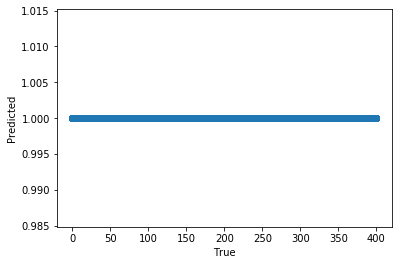

0

In [16]:
net_LCT.plot_scatter()

In [ ]:
### 4. deploy the trained network on your genomic data of interest


In [ ]:
    model.predict(gene_LCT.data, batch_size=None)